In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
# Uncomment the next line to train on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [ ]:
# Cell 3: Define Constants
image_height = 2479
image_width = 3542
batch_size = 4
num_classes = 423


In [ ]:
# Cell 4: Load VGG16 Base Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[:-10]:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Cell 5: Define Functions for File Paths and Data Splitting
def get_file_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

# Get file paths for each set
train_files = get_file_paths('/content/drive/MyDrive/Dataset/Train')
val_files = get_file_paths('/content/drive/MyDrive/Dataset/Validate')
test_files = get_file_paths('/content/drive/MyDrive/Dataset/Test')

# Create DataFrames and Split Data
train_df = pd.DataFrame({'file_path': train_files, 'label': ['train'] * len(train_files)})
val_df = pd.DataFrame({'file_path': val_files, 'label': ['validate'] * len(val_files)})
test_df = pd.DataFrame({'file_path': test_files, 'label': ['test'] * len(test_files)})
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

train_data, val_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, stratify=val_data['label'], random_state=42)


In [ ]:
# Cell 6: Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='file_path',
    y_col='label',
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 423 validated image filenames belonging to 3 classes.


In [ ]:
val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='file_path',
    y_col='label',
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 53 validated image filenames belonging to 3 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='file_path',
    y_col='label',
    target_size=(256,256),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 53 validated image filenames belonging to 3 classes.


In [ ]:
# Cell 10: Build the Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])


In [ ]:
# Cell 11: Define Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20:
        lr *= 0.5
    elif epoch > 30:
        lr *= 0.2
    return lr


In [ ]:
# Cell 12: Create Callback for F1 Score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on validation data
        val_predictions = self.model.predict(val_generator)

        # Concatenate predictions and true labels over all batches
        val_true_labels = []
        val_pred_labels = []

        for i in range(len(val_generator)):
            batch_data, batch_labels = val_generator[i]
            val_true_labels.extend(np.argmax(batch_labels, axis=1))
            val_pred_labels.extend(np.argmax(val_predictions[i], axis=0))

        # Convert to numpy arrays
        val_true_labels = np.array(val_true_labels)
        val_pred_labels = np.array(val_pred_labels)

        # Calculate F1 score
        f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

        print(f'F1 Score: {f1:.4f}')


In [ ]:
# Cell 13: Train the Model
lr_scheduler = LearningRateScheduler(lr_schedule)
f1_score_callback = F1ScoreCallback()

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[lr_scheduler])

Epoch 1/10
106/106 [==============================] - 761s 7s/step - loss: 25.1295 - accuracy: 0.6785 - precision: 0.6788 - recall: 0.6596 - val_loss: 0.8741 - val_accuracy: 0.6981 - val_precision: 0.6981 - val_recall: 0.6981 - lr: 0.0010
Epoch 2/10
106/106 [==============================] - 810s 8s/step - loss: 0.9728 - accuracy: 0.7021 - precision: 0.6961 - recall: 0.6714 - val_loss: 0.8327 - val_accuracy: 0.6981 - val_precision: 0.6981 - val_recall: 0.6981 - lr: 0.0010
Epoch 3/10
106/106 [==============================] - 803s 8s/step - loss: 0.9615 - accuracy: 0.6879 - precision: 0.6940 - recall: 0.6809 - val_loss: 0.8217 - val_accuracy: 0.6981 - val_precision: 0.6981 - val_recall: 0.6981 - lr: 0.0010
Epoch 4/10
106/106 [==============================] - 753s 7s/step - loss: 0.8367 - accuracy: 0.6998 - precision: 0.7032 - recall: 0.6832 - val_loss: 0.8316 - val_accuracy: 0.6981 - val_precision: 0.6981 - val_recall: 0.6981 - lr: 0.0010
Epoch 5/10
106/106 [===========================

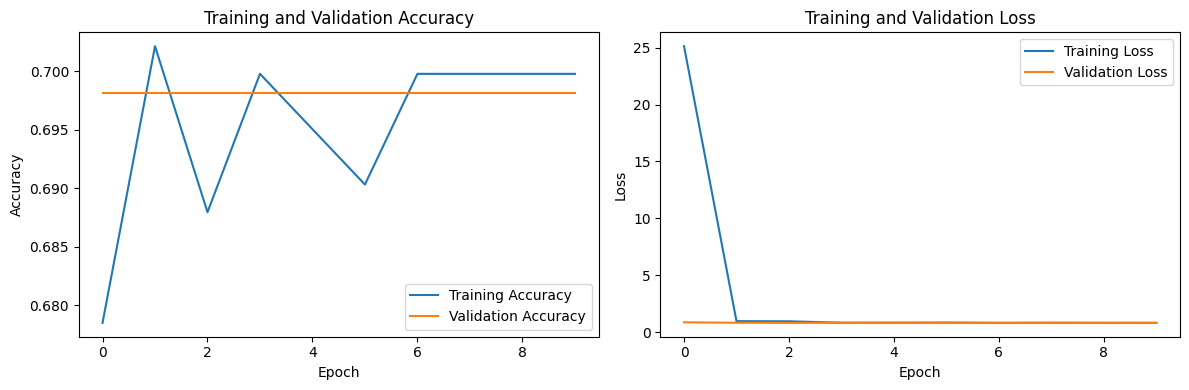

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Evaluate the model on the test set
test_results = model.evaluate(test_generator)
test_loss = test_results[0]
test_accuracy = test_results[1]
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


14/14 [==============================] - 46s 3s/step - loss: 0.8262 - accuracy: 0.6981 - precision: 0.6981 - recall: 0.6981
Test Loss: 0.8262
Test Accuracy: 0.6981


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2479, 3542, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 2479, 3542, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 2479, 3542, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 1239, 1771, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, 1239, 1771, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 1239, 1771, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 619, 885, 128)     0     